# Predicting psychiatric readmission from clinical notes
Data source: MIMIC III (https://mimic.physionet.org/)
This notebook will combine 2 tables from MIMIC III to collect unique admissions and corresponding discharge notes for patients diagnosed with mental illnesses. <br>
- NOTEEVENTS.csv: https://mimic.physionet.org/mimictables/noteevents/ <br>
- ADMISSIONS.csv: https://mimic.physionet.org/mimictables/admissions/ <br>
<br>
Data labelling:
- Readmission (positive class): if an admission is followed by another admission
- No readmission (negative class): if an admission is not followed by another admission

### Merge data

In [2]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
data = pd.read_csv('NOTEEVENTS.csv')
admit = pd.read_csv('ADMISSIONS.csv')

In [4]:
data.head()

,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT
0,174,22532,167853.0,2151-08-04,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2151-7-16**] Dischar...
1,175,13702,107527.0,2118-06-14,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2118-6-2**] Discharg...
2,176,13702,167118.0,2119-05-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2119-5-4**] D...
3,177,13702,196489.0,2124-08-18,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2124-7-21**] ...
4,178,26880,135453.0,2162-03-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2162-3-3**] D...


In [5]:
admit.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1


In [6]:
#Merge these two datasets and select features of interest
note = data[['SUBJECT_ID','HADM_ID','CHARTDATE','CATEGORY','TEXT']]
admission = admit[['HADM_ID','ADMITTIME','DISCHTIME','DIAGNOSIS']]
discharge = note.merge(admission,how='inner', on='HADM_ID')
discharge.head()

,SUBJECT_ID,HADM_ID,CHARTDATE,CATEGORY,TEXT,ADMITTIME,DISCHTIME,DIAGNOSIS
0,22532,167853.0,2151-08-04,Discharge summary,Admission Date: [**2151-7-16**] Dischar...,2151-07-16 14:29:00,2151-08-04 19:10:00,RT LOWER LOBE PNEUMONIA
1,22532,167853.0,2151-08-04,Discharge summary,Admission Date: [**2151-7-16**] Dischar...,2151-07-16 14:29:00,2151-08-04 19:10:00,RT LOWER LOBE PNEUMONIA
2,22532,167853.0,2151-08-02,Echo,PATIENT/TEST INFORMATION:\nIndication: Aortic ...,2151-07-16 14:29:00,2151-08-04 19:10:00,RT LOWER LOBE PNEUMONIA
3,22532,167853.0,2151-07-19,Echo,PATIENT/TEST INFORMATION:\nIndication: Endocar...,2151-07-16 14:29:00,2151-08-04 19:10:00,RT LOWER LOBE PNEUMONIA
4,22532,167853.0,2151-08-03,ECG,Atrial fibrillation with a slow ventricular re...,2151-07-16 14:29:00,2151-08-04 19:10:00,RT LOWER LOBE PNEUMONIA


In [7]:
discharge['CATEGORY'].unique()

array(['Discharge summary', 'Echo', 'ECG', 'Radiology', 'Nursing/other',
       'Physician ', 'Nursing', 'Rehab Services', 'Nutrition',
       'Respiratory ', 'General', 'Social Work', 'Case Management ',
       'Pharmacy', 'Consult'], dtype=object)

In [11]:
#Select only discharge notes
discharge = discharge[discharge['CATEGORY']=='Discharge summary']
print('Total discharge notes: ', discharge.shape[0])
print('Total unique admissions: ', discharge['HADM_ID'].nunique())
print('Total unique patients: ', discharge['SUBJECT_ID'].nunique())

Total discharge notes:  59652
Total unique admissions:  52726
Total unique patients:  41127


In [12]:
#NOTE: the number of discharge notes are even higher than number of unique visits -> there could be duplicate, we will use only one
# discharge note per visit
disch = discharge.groupby(["HADM_ID"]).last().reset_index()
disch.sort_values('SUBJECT_ID', axis = 0, ascending = True, 
                 inplace = True, na_position ='last')

### Create the label: *READMIT: 0 OR 1*

In [16]:
#Find patients with multiple admissions
patient_visits = disch['SUBJECT_ID'].value_counts().reset_index()
patient_multivisit = patient_visits[patient_visits['SUBJECT_ID'] >1]
patient_multivisit_id = patient_multivisit['index']

In [17]:
#replace class = 1 for those with multiple visits ----- user -level
disch['READMIT'] = 0
disch.loc[disch.SUBJECT_ID.isin(patient_multivisit_id), 'READMIT'] =  1

In [18]:
#replace class = 0 for the last visits per user ----- visit -level
multivisit_groupby_user = disch.groupby(["SUBJECT_ID"])[['HADM_ID','DISCHTIME']].max().reset_index()

In [19]:
#double check -> same number -> good
multivisit_groupby_user.shape, multivisit_groupby_user['SUBJECT_ID'].shape

((41127, 3), (41127,))

In [20]:
last_visit_hadm = multivisit_groupby_user['HADM_ID'].to_list()
disch.loc[disch.HADM_ID.isin(last_visit_hadm), 'READMIT'] =  0

In [21]:
disch['READMIT'].value_counts() # -----> perfect!

0    41127
1    11599
Name: READMIT, dtype: int64

### Filter for mental diseases

1. Mental disease code 2900-3200
2. Selfharm
3. Drugcodes

In [22]:
#merge diagnosis
diag = pd.read_csv('DIAGNOSES_ICD.csv')
diag.head(5)

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,1297,109,172335,1.0,40301
1,1298,109,172335,2.0,486
2,1299,109,172335,3.0,58281
3,1300,109,172335,4.0,5855
4,1301,109,172335,5.0,4254


In [23]:
#Select code for mental illnesses
mental = list(np.arange(2900,3200, 1))
mental = [str(x) for x in mental]
selfharmcodes = ["E" + str(x) for x in np.arange(9500, 9600, 1)]
sample = mental + selfharmcodes
len(sample)

400

In [27]:
mental = diag[diag["ICD9_CODE"].astype(str).isin(sample)]
data = disch.merge(mental[['HADM_ID','ICD9_CODE']],how='inner', on='HADM_ID')
data.head()

,HADM_ID,SUBJECT_ID,CHARTDATE,CATEGORY,TEXT,ADMITTIME,DISCHTIME,DIAGNOSIS,READMIT,ICD9_CODE
0,100006.0,9895,2108-04-18,Discharge summary,"Name: [**Known lastname 470**], [**Known firs...",2108-04-06 15:49:00,2108-04-18 17:18:00,COPD FLARE,1,3090
1,100020.0,9973,2142-12-10,Discharge summary,Admission Date: [**2142-11-30**] ...,2142-11-30 01:53:00,2142-12-10 16:32:00,HYPONATREMIA,1,2930
2,100035.0,48539,2115-03-19,Discharge summary,Admission Date: [**2115-2-22**] ...,2115-02-22 06:51:00,2115-03-19 14:37:00,POST ARREST,0,3004
3,100036.0,30078,2187-07-23,Discharge summary,"Name: [**Known lastname **],[**Known firstnam...",2187-07-13 13:58:00,2187-07-23 15:45:00,CHF,0,2948
4,100058.0,14121,2139-09-26,Discharge summary,Admission Date: [**2139-9-8**] Discharge ...,2139-09-08 21:38:00,2139-09-26 13:55:00,INTRACRANIAL HEMORRHAGE,0,3051


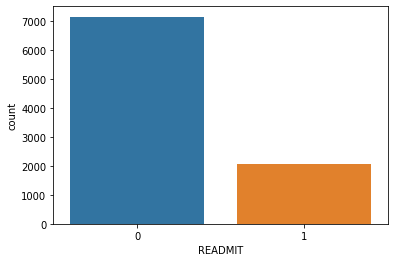

In [28]:
#Check for class imbalance
sns.countplot(data['READMIT'])

In [29]:
data['READMIT'].value_counts()

0    7159
1    2059
Name: READMIT, dtype: int64

In [140]:
#data.to_csv('final_data.csv')

### Data cleaning using regex

In [46]:
print('Before cleaning:')
note['TEXT'].iloc[1]

Before cleaning:


'Admission Date:  [**2118-6-2**]       Discharge Date:  [**2118-6-14**]\n\nDate of Birth:                    Sex:  F\n\nService:  MICU and then to [**Doctor Last Name **] Medicine\n\nHISTORY OF PRESENT ILLNESS:  This is an 81-year-old female\nwith a history of emphysema (not on home O2), who presents\nwith three days of shortness of breath thought by her primary\ncare doctor to be a COPD flare.  Two days prior to admission,\nshe was started on a prednisone taper and one day prior to\nadmission she required oxygen at home in order to maintain\noxygen saturation greater than 90%.  She has also been on\nlevofloxacin and nebulizers, and was not getting better, and\npresented to the [**Hospital1 18**] Emergency Room.\n\nIn the [**Hospital3 **] Emergency Room, her oxygen saturation was\n100% on CPAP.  She was not able to be weaned off of this\ndespite nebulizer treatment and Solu-Medrol 125 mg IV x2.\n\nReview of systems is negative for the following:  Fevers,\nchills, nausea, vomiting, nigh

In [45]:
data["TEXT"] = data["TEXT"].apply(lambda x: re.sub(r'\r\n', " ", str(x)))
data["TEXT"] = data["TEXT"].apply(lambda x: re.sub(r'\n\n', " ", str(x)))
data["TEXT"] = data["TEXT"].apply(lambda x: re.sub(r'\n', " ", str(x)))
data["TEXT"] = data["TEXT"].apply(lambda x: re.sub(r'[\[\]*#]', " ", str(x)))
print('After cleaning: ')
data['TEXT'].iloc[1]

After cleaning: 


"Admission Date:     2142-11-30                 Discharge Date:      2142-12-10    Date of Birth:     2084-5-2                Sex:   M Service: MEDICINE Allergies: Percocet / Bactrim Ds / Lisinopril Attending:   First Name3 (LF) 898    Chief Complaint: hypotension Major Surgical or Invasive Procedure: none History of Present Illness: Mr.    Known lastname 25925    is a 58 yo m w/ multiple sclerosis and seizure disorder who presented to an OSH for delusions and AMS x 2 days. At OSH, he was noted to have a Na of 124. He does have a history of hyponatremia; he had a Na of 117 in    2-27    but had been in the mid 130s since then. He has seen nephrology. At the OSH, he had an approx 45sec generalized tonic clonic seizure, received 1mg Ativan, and transferred to the ED at    Hospital1 18   . He also has a history of seizures especially in the setting of infection and hyponatremia. It is unclear if he has had seizures without an inciting event. He is currently being weaned off of Keppra and 

In [47]:
datause = data[['READMIT','TEXT', 'SUBJECT_ID']]
datause.head()

,READMIT,TEXT,SUBJECT_ID
0,1,"Name: Known lastname 470 , Known firs...",9895
1,1,Admission Date: 2142-11-30 ...,9973
2,0,Admission Date: 2115-2-22 ...,48539
3,0,"Name: Known lastname , Known firstnam...",30078
4,0,Admission Date: 2139-9-8 Discharge ...,14121


In [33]:
### Check for missing values
print('Number of rows missing notes: ',datause['TEXT'].isna().sum())

Number of rows missing notes:  0


### Split train, val, test data

In [49]:
y = datause['READMIT']
X = datause[['TEXT','SUBJECT_ID']]

X_train, X_testval, y_train, y_testval = train_test_split(X, y,test_size=0.4,random_state=0,stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_testval, y_testval,test_size=0.5,random_state=0,stratify=y_testval)

#Merge them to get the final sets
dtrain = pd.concat([X_train, y_train], axis=1)
dval = pd.concat([X_val, y_val], axis=1)
dtest = pd.concat([X_test, y_test], axis=1)

dtrain.shape, dtest.shape, dval.shape

((5530, 3), (1844, 3), (1844, 3))

Text(0.5, 0, 'Class')

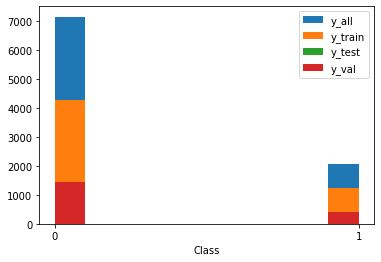

In [50]:
#Check class imbalance in each dataset
plt.hist(data['READMIT'], label='y_all') #y from the full dataset
plt.hist(dtrain['READMIT'],label ='y_train')
plt.hist(dtest['READMIT'],label ='y_test')
plt.hist(dval['READMIT'],label ='y_val')
plt.legend()
plt.xticks([0,1])
plt.xlabel('Class')

In [43]:
print('Full data')
print(data['READMIT'].value_counts())
print('Training data')
print(dtrain['READMIT'].value_counts())
print('Validation data')
print(dval['READMIT'].value_counts())
print('Test data')
print(dtest['READMIT'].value_counts())

Full data
0    7159
1    2059
Name: READMIT, dtype: int64
Training data
0    4295
1    1235
Name: READMIT, dtype: int64
Validation data
0    1432
1     412
Name: READMIT, dtype: int64
Test data
0    1432
1     412
Name: READMIT, dtype: int64


In [51]:
print('Total unique patients in training data: ', dtrain['SUBJECT_ID'].nunique())
print('Total unique patients in validation data: ', dval['SUBJECT_ID'].nunique())
print('Total unique patients in test data: ', dtest['SUBJECT_ID'].nunique())

Total unique patients in training data:  4630
Total unique patients in validation data:  1716
Total unique patients in test data:  1721


In [52]:
#Save data
dtrain.to_csv('project_dtrain_clean.csv')
dval.to_csv('project_dval_clean.csv')
dtest.to_csv('project_dtest_clean.csv')